In [59]:
# essential python libraries
import numpy as np
import pandas as pd

In [60]:
# preprocessing 
from preprocessing import create_column_filter, apply_column_filter
from preprocessing import create_imputation, apply_imputation
from preprocessing import create_normalization, apply_normalization
from preprocessing import accuracy, auc, brier_score, split

In [61]:
# sklearn models
import os
import time
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import recall_score, precision_score

# Data loading

In [62]:
training = pd.read_csv("training_df.csv")

In [63]:
# drop unwanted columns
training = training.drop(columns = 'Unnamed: 0', axis = 1)
training = training.drop(columns = 'SMILES', axis = 1)

In [64]:
# rename ACTIVE to CLASS, so we can use our preprocessing functions
training = training.rename(columns={"INDEX": "ID"})
training = training.rename(columns={"Active": "CLASS"})

In [65]:
training

,ID,nrAtoms,ExactMolWT,Fragments,Lipinski,CLASS,fp_0,fp_1,fp_2,fp_3,...,fp_114,fp_115,fp_116,fp_117,fp_118,fp_119,fp_120,fp_121,fp_122,fp_123
0,1.0,18.0,245.105193,0.0,18.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.0,26.0,376.082599,0.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,3.0,25.0,382.040562,0.0,25.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,4.0,27.0,427.052418,0.0,27.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,5.0,24.0,329.148789,0.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121369,121370.0,23.0,354.082032,0.0,23.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
121370,121371.0,18.0,246.136828,0.0,18.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
121371,121372.0,29.0,405.088019,0.0,29.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
121372,121373.0,26.0,361.076179,0.0,26.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Train and validation split

Data preparation needs to be done only on the training set (so after splitting has been done). The preprocessing will in this way be fitted to the training set and then be applied onto both the training and test set. A 80/20% split is choosen for the train and test set.

In [66]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(training, test_size=0.2, random_state=42)

## Handling imbalanced data set 

In [67]:
def under_sample(train_df):
    false_sample = train_df[train_df["CLASS"] == 1]
    true_sample = train_df[train_df["CLASS"] == 0].sample(n=false_sample.shape[0])
    return pd.concat([false_sample, true_sample]).sample(frac=1).reset_index(drop=True)

In [68]:
def over_sample(train_df):
    false_sample = train_df[train_df["CLASS"] == 0]
    true_sample = train_df[train_df["CLASS"] == 1].sample(n=false_sample.shape[0], replace=True)
    return pd.concat([false_sample, true_sample]).sample(frac=1).reset_index(drop=True)

In [69]:
train_df = under_sample(train_df)

## Further split

In [70]:
X_train = train_df.copy().drop(columns = 'CLASS')
y_train = train_df['CLASS']

In [71]:
X_test = val_df.copy().drop(columns = 'CLASS')
y_test = val_df['CLASS']

In [72]:
y_train.value_counts()

1.0    9589
0.0    9589
Name: CLASS, dtype: int64

# Preprocessing

Preprocessing is being fit to the training data set and then applied on both train and validation set.

## Check for missing data

In [73]:
#Find columns with null values 
null_columns = training.columns[training.isnull().any()]
training[null_columns].isnull().sum()

Series([], dtype: float64)

## Outliers detection

In [74]:
# import to detect outliers
from scipy import stats

# Get Z-value 
z_df = X_train.copy().drop(columns = ['ID'], axis = 1)
z_training = np.abs(stats.zscore(z_df))

# Nr. of outliers over 3,4,5 stds
traing_z_3 = np.where(z_training > 3)[0]
traing_z_4 = np.where(z_training > 4)[0]
traing_z_5 = np.where(z_training > 5)[0]

# Printing 
print("Precentage 1 stds away: {:.0f}".format(len(traing_z_3)/z_training.shape[0]*100))
print("Precentage 2 stds away: {:.0f}".format(len(traing_z_4)/z_training.shape[0]*100))
print("Precentage 3 stds away: {:.0f}".format(len(traing_z_5)/z_training.shape[0]*100))

Precentage 1 stds away: 18
Precentage 2 stds away: 9
Precentage 3 stds away: 9


c. 8% of outliers > 5std

Let's take a note of these outliers. However, we will not remove these outliers for now as they probably serve legitimate observations of the chemical compunds and are interesting for the prediction.

In [75]:
pd.DataFrame(data = [['1 std', '2 std', '3std'],
                     [len(traing_z_3)/z_training.shape[0]*100, len(traing_z_4)/z_training.shape[0]*100,
                      len(traing_z_5)/z_training.shape[0]*100]], 
             columns = ['stds away from mean', 'fraction of data set'])

ValueError: 2 columns passed, passed data had 3 columns

In [76]:
outliers = pd.DataFrame(data = [{'1 std':len(traing_z_3)/z_training.shape[0]*100}, 
                     {'2 std':len(traing_z_4)/z_training.shape[0]*100}
                     , {'3 std':len(traing_z_5)/z_training.shape[0]*100}])

<AxesSubplot:>

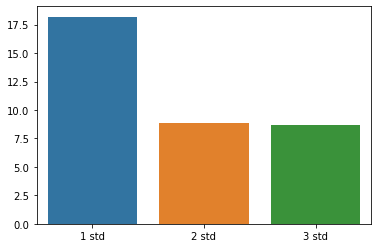

In [77]:
sns.barplot(data = outliers)

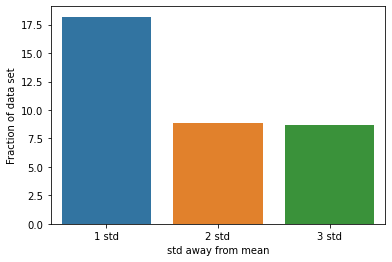

In [78]:
ax = sns.barplot(data = outliers)
ax.set(xlabel='std away from mean', ylabel='Fraction of data set')
plt.show()

# Normalization

In [19]:
list(X_train[['nrAtoms', 'ExactMolWT', 'Fragments', 'Lipinski']].columns)

['nrAtoms', 'ExactMolWT', 'Fragments', 'Lipinski']

In [20]:
# Normalization - minmax
X_train_minmax, normalization = create_normalization(X_train, normalizationtype = "minmax")
X_test_minmax = apply_normalization(X_test, normalization)

In [21]:
X_train_minmax.describe()

,ID,nrAtoms,ExactMolWT,Fragments,Lipinski,fp_0,fp_1,fp_2,fp_3,fp_4,...,fp_114,fp_115,fp_116,fp_117,fp_118,fp_119,fp_120,fp_121,fp_122,fp_123
count,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,...,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000
mean,60770.352644,0.265317,0.257788,0.006612,0.265317,0.126760,0.241631,0.321097,0.399885,0.174419,...,0.188028,0.157733,0.123944,0.118991,0.177547,0.249087,0.355407,0.405047,0.915893,0.106059
std,34977.492340,0.067346,0.069522,0.038996,0.067346,0.332712,0.428083,0.466910,0.489887,0.379479,...,0.390745,0.364500,0.329526,0.323786,0.382141,0.432496,0.478649,0.490914,0.277555,0.307921
min,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30560.250000,0.224719,0.211344,0.000000,0.224719,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,60775.000000,0.258427,0.255117,0.000000,0.258427,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,90978.750000,0.303371,0.301373,0.000000,0.303371,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,121367.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
normalization

{'nrAtoms': ('minmax', 1.0, 90.0),
 'ExactMolWT': ('minmax', 41.026549096, 1252.6379767359995),
 'Fragments': ('minmax', 0.0, 5.0),
 'Lipinski': ('minmax', 1.0, 90.0)}

In [23]:
# Normalizaiton - zscore
X_train_zscore, normalization = create_normalization(X_train, normalizationtype = "zscore")
X_test_zscore = apply_normalization(X_test, normalization)

In [24]:
X_train_zscore.describe()

,ID,nrAtoms,ExactMolWT,Fragments,Lipinski,fp_0,fp_1,fp_2,fp_3,fp_4,...,fp_114,fp_115,fp_116,fp_117,fp_118,fp_119,fp_120,fp_121,fp_122,fp_123
count,19178.000000,1.917800e+04,1.917800e+04,1.917800e+04,1.917800e+04,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,...,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000
mean,60770.352644,-2.065531e-17,1.586459e-14,1.653163e-15,-2.065531e-17,0.126760,0.241631,0.321097,0.399885,0.174419,...,0.188028,0.157733,0.123944,0.118991,0.177547,0.249087,0.355407,0.405047,0.915893,0.106059
std,34977.492340,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.332712,0.428083,0.466910,0.489887,0.379479,...,0.390745,0.364500,0.329526,0.323786,0.382141,0.432496,0.478649,0.490914,0.277555,0.307921
min,7.000000,-3.939591e+00,-3.708022e+00,-1.695510e-01,-3.939591e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30560.250000,-6.028213e-01,-6.680473e-01,-1.695510e-01,-6.028213e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,60775.000000,-1.023058e-01,-3.841494e-02,-1.695510e-01,-1.023058e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,90978.750000,5.650482e-01,6.269340e-01,-1.695510e-01,5.650482e-01,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,121367.000000,1.090903e+01,1.067598e+01,2.547437e+01,1.090903e+01,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Zscore handles outliers better which is as seen apparent in the data set. However the features does not belong to the same scale. 

Let us try out both minmax and zscore in our predicitons and evaluate performace.

# Baseline model

In [25]:
dt = DecisionTreeClassifier(criterion = "gini", splitter = "best", max_depth=8).fit(X_train, y_train)

In [26]:
predictions = dt.predict(X_test)
#predicitons = pd.DataFrame(predictions)
print("Accuracy: {:.4f}".format(accuracy(pd.DataFrame(predictions), y_test)))
print("AUC: {:.4f}".format(auc(pd.DataFrame(predictions), y_test)))  # Comment this out if not implemented in assignment 1
## Comment this out if not implemented in assignment 1
print("Brier score: {:.4f}".format(brier_score(pd.DataFrame(predictions), y_test)))

Accuracy: 0.9010
AUC: 0.3878
Brier score: 0.6278


In [27]:
pd.DataFrame(predictions)

,0
0,0.0
1,1.0
2,1.0
3,0.0
4,0.0
...,...
24270,1.0
24271,1.0
24272,0.0
24273,0.0


In [28]:
y_test

25810     0.0
71590     0.0
71598     0.0
34947     0.0
36616     0.0
         ... 
78665     0.0
112910    1.0
20950     0.0
85325     0.0
113649    0.0
Name: CLASS, Length: 24275, dtype: float64

In [29]:
rf = RandomForestClassifier(criterion = "gini", max_features = "log2", max_depth=8).fit(X_train, y_train)

In [30]:
predictions = rf.predict(X_test)
#predicitons = pd.DataFrame(predictions)
print("Accuracy: {:.4f}".format(accuracy(pd.DataFrame(predictions), y_test)))
print("AUC: {:.4f}".format(auc(pd.DataFrame(predictions), y_test)))  # Comment this out if not implemented in assignment 1
## Comment this out if not implemented in assignment 1
print("Brier score: {:.4f}".format(brier_score(pd.DataFrame(predictions), y_test)))

Accuracy: 0.9010
AUC: 0.3314
Brier score: 0.6272


# Feature analysis

## Permutation importance 

In [31]:
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
# get the permutation_importance of classifier
result = permutation_importance(dt, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=-2)
# sort on importance
sorted_idx = result.importances_mean.argsort()
#top15_idx = sorted_idx[:15]

# plot
fig, ax = plt.subplots(figsize=(20, 50))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances Decision Tree Classifier", fontsize=30)
fig.tight_layout()

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)

plt.show()

KeyboardInterrupt: 

## Decision tree feature importance 

In [ ]:
# get feauture names
feature_names = X_train.columns

# get feauture importance
tree_feature_importances = dt.feature_importances_

# sort with respect to feature importance 
sorted_idx = tree_feature_importances.argsort()

# plotting
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(20, 50))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Decision Tree Feature Importances", fontsize=30)
fig.tight_layout()

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)

plt.show()

## Hierarchical clustering

In [ ]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

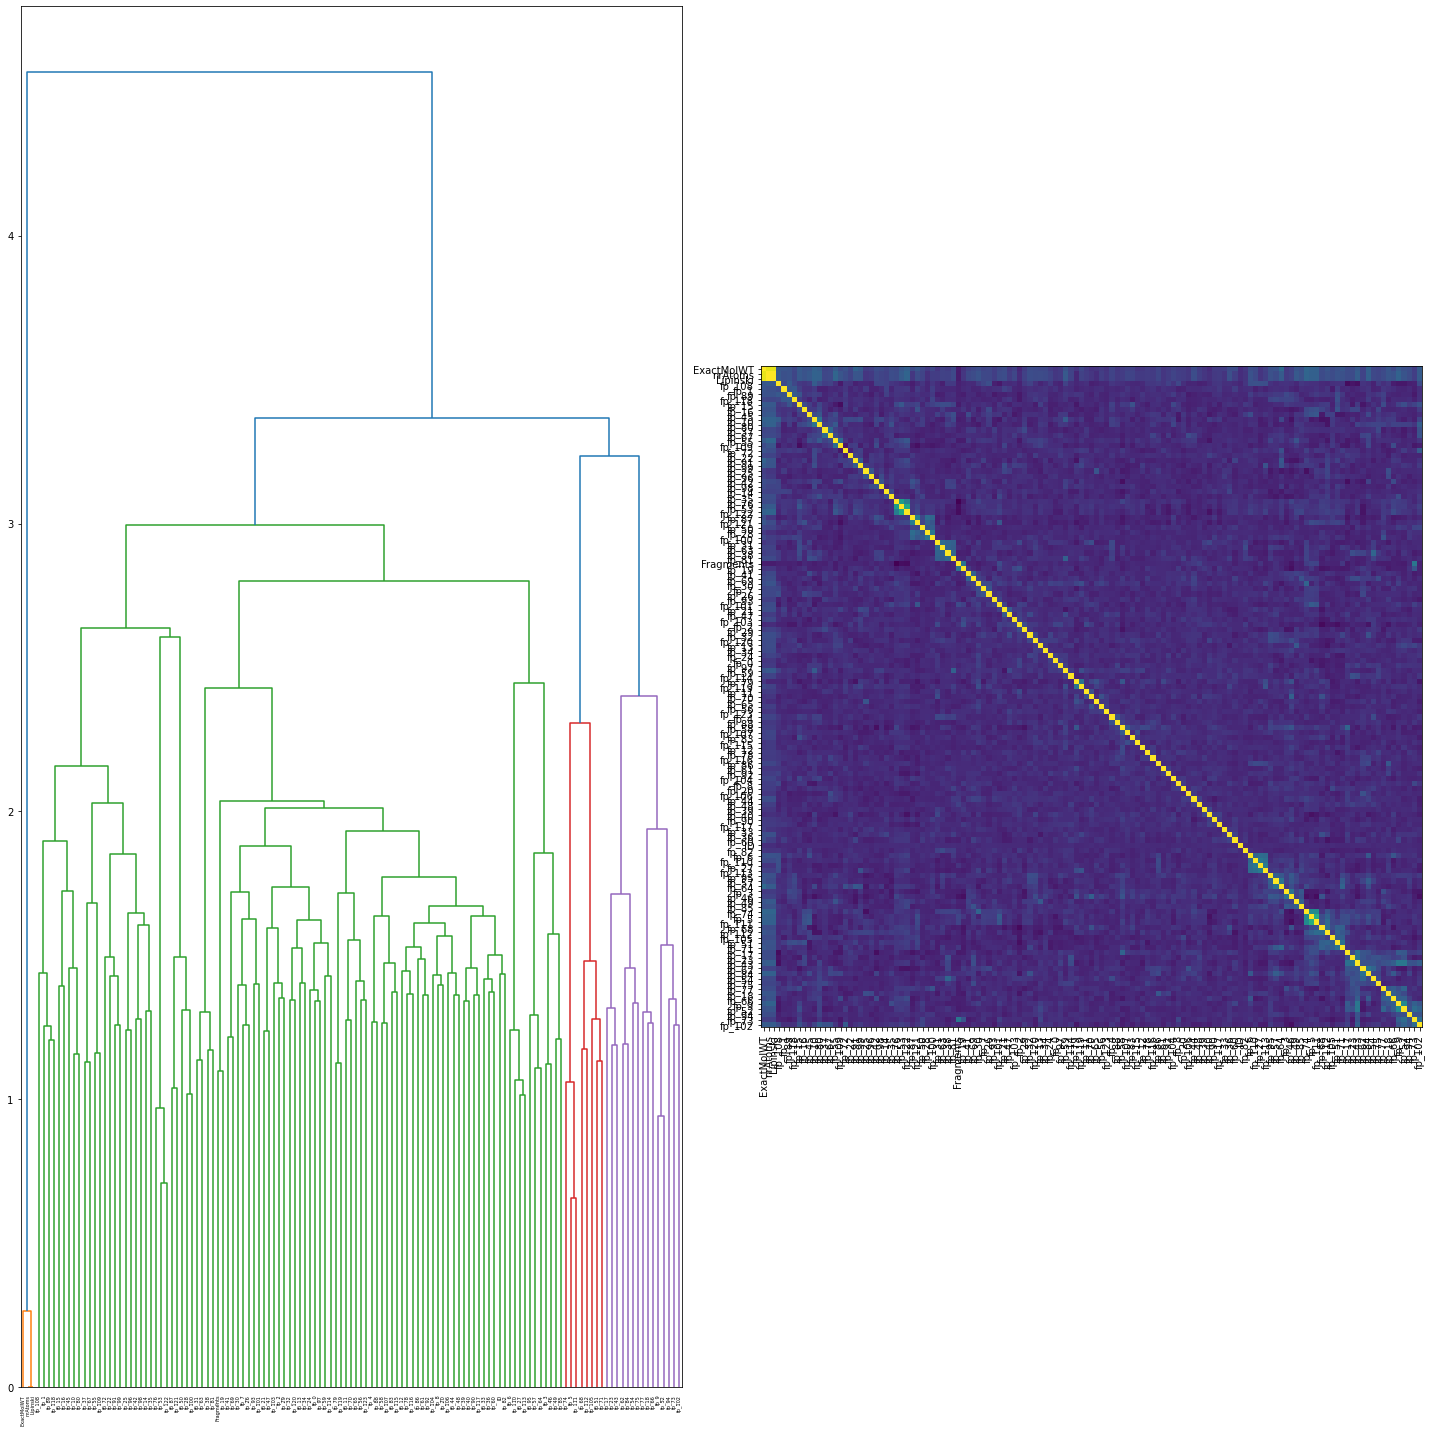

In [33]:
# Hierarchical cluster and correlation matrix

feature_names = X_train.columns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
corr = spearmanr(X_train).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

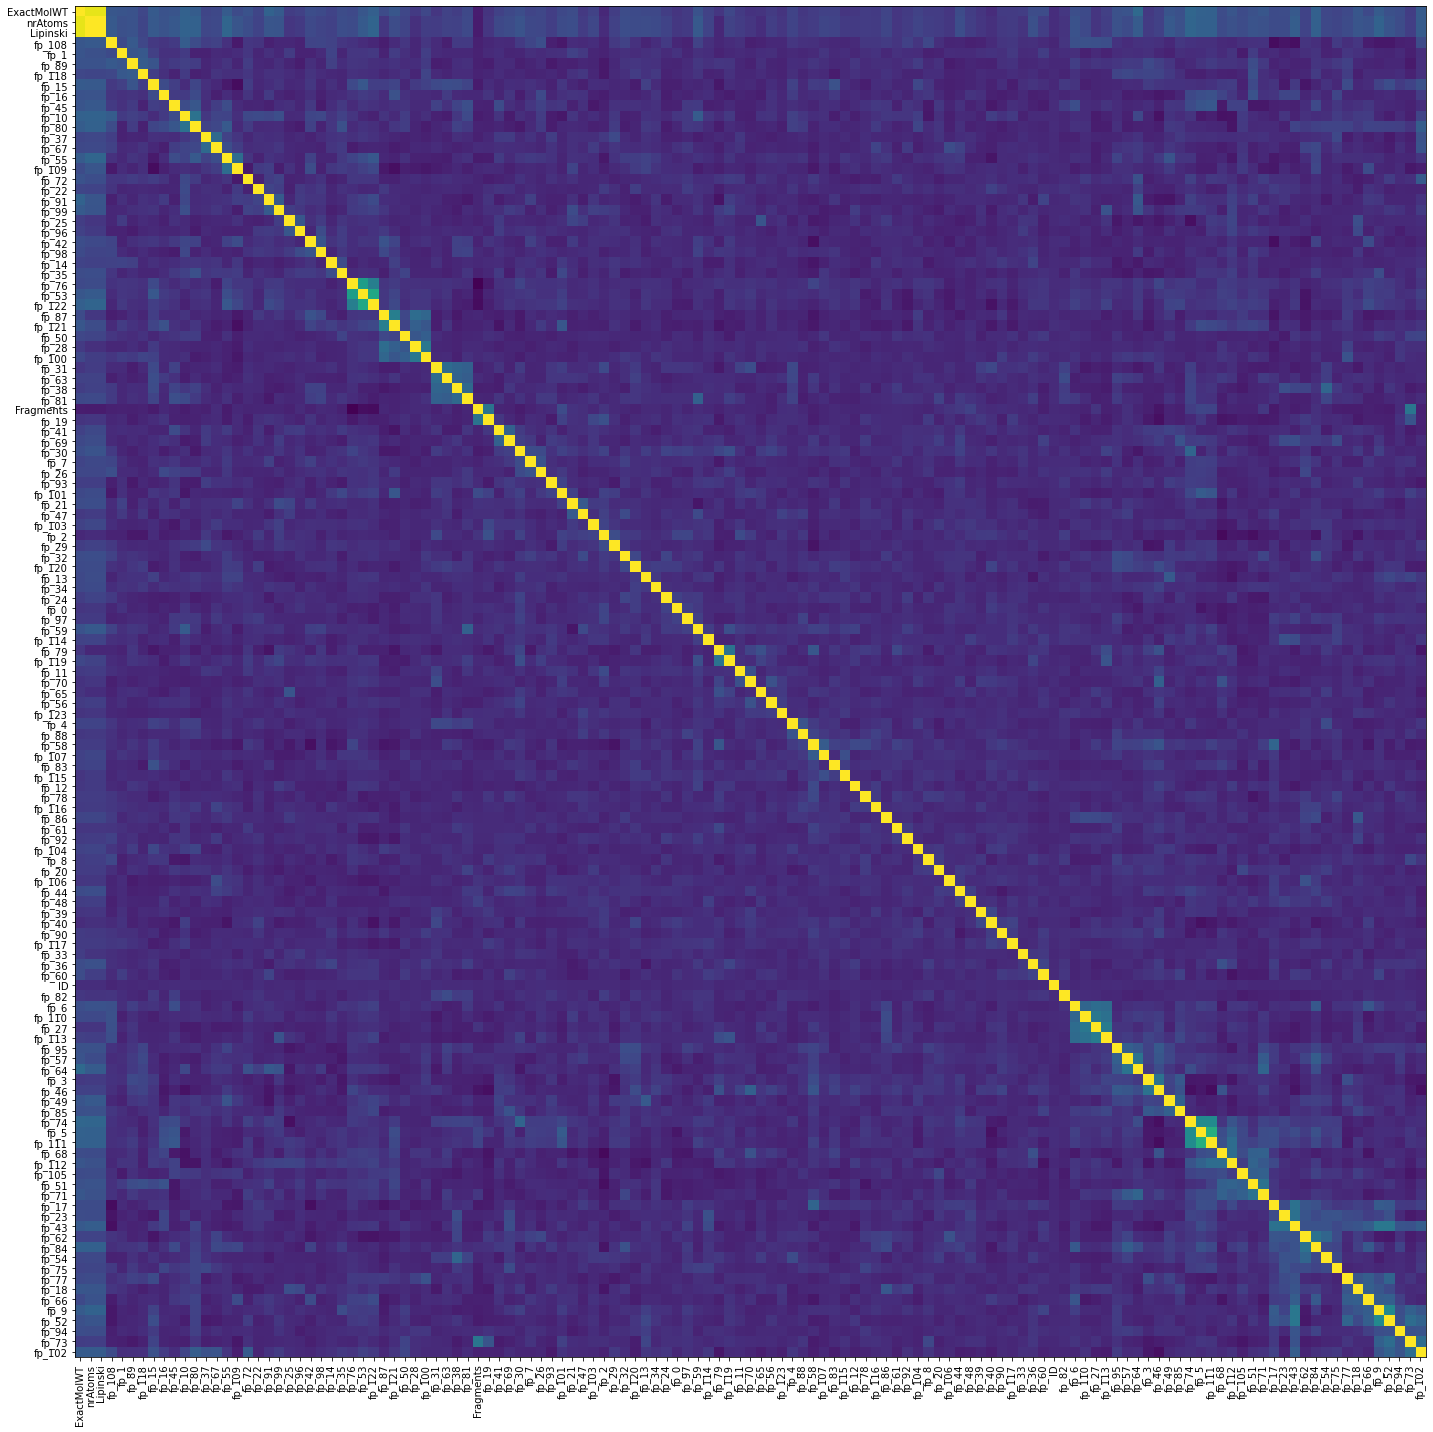

In [34]:
# Only correlation matrix

feature_names = X_train.columns

fig, (ax2) = plt.subplots(figsize=(20, 20))
corr = spearmanr(X_train).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

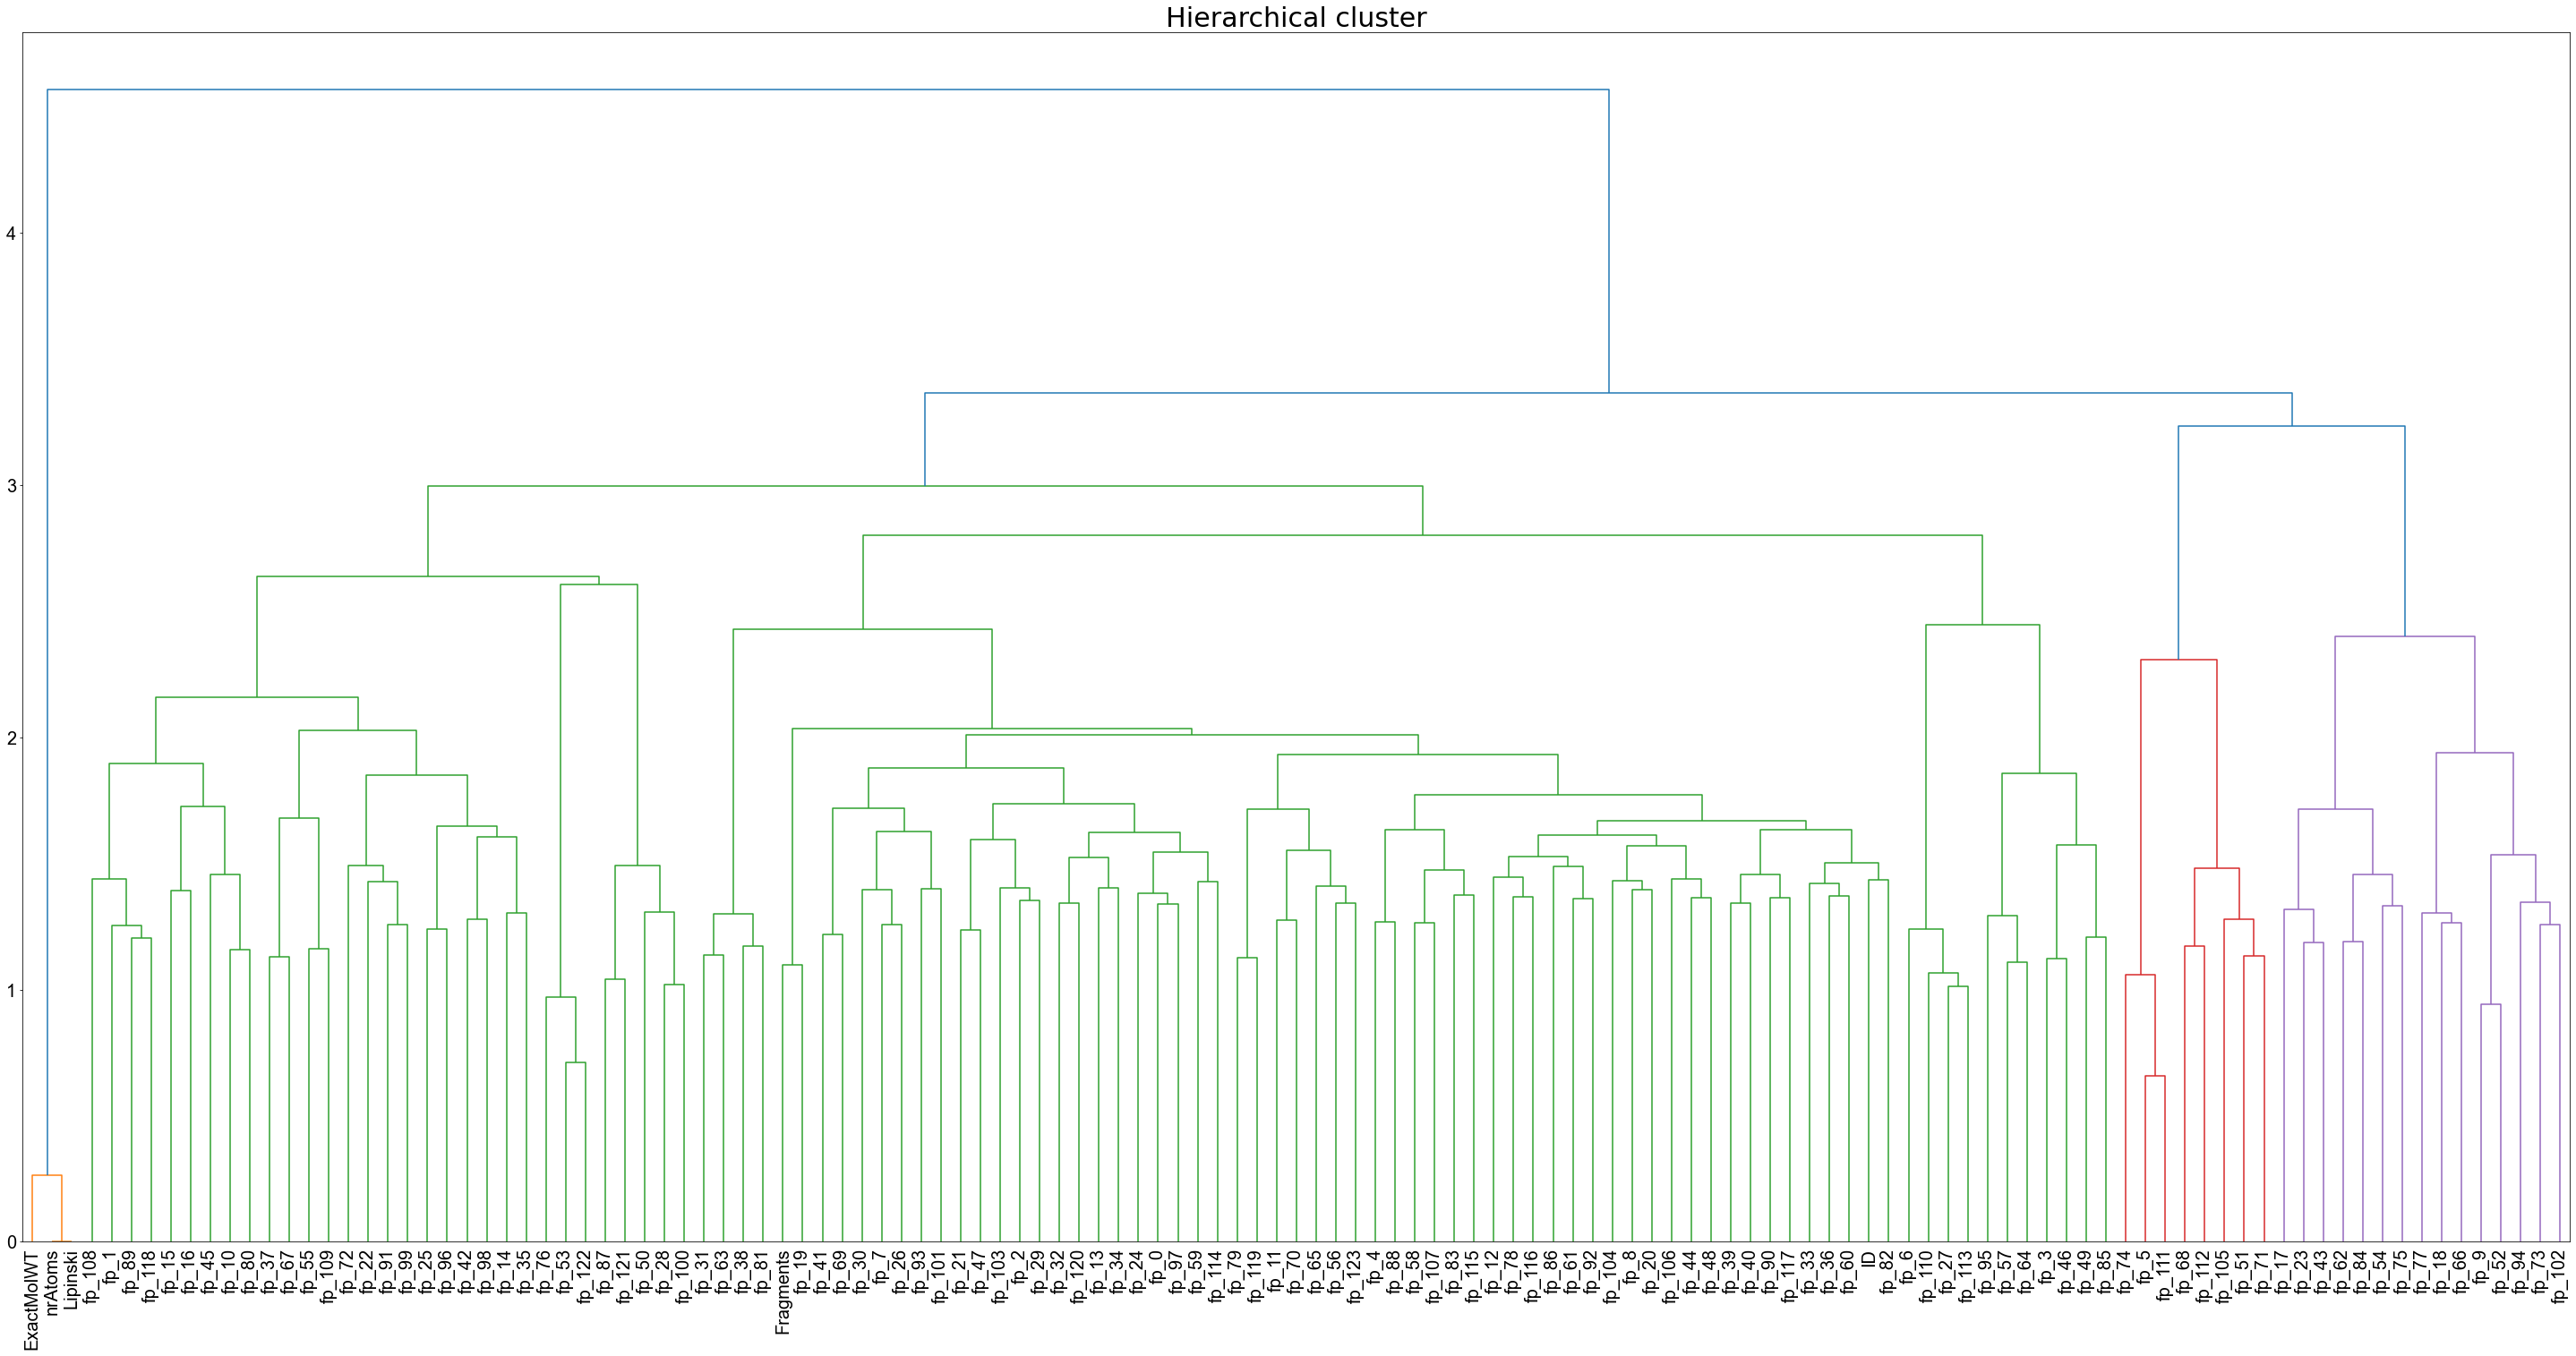

In [35]:
# Only showing hierarchical cluster

feature_names = X_train.columns

fig, ax1 = plt.subplots(figsize=(40, 20))
corr = spearmanr(X_train).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
ax1.set_title("Hierarchical cluster", fontsize=30)
fig.tight_layout()

for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)

plt.show()

Lipinksi and nrAtoms upshow a high collinearity. 

# Feature selection

Let us make a data set without using Lipinski.

# Dimensionality reduction - PCA

In [33]:
from sklearn.decomposition import PCA

In [34]:
X_train = X_train.copy().drop(columns=['ID'], axis = 1)

In [35]:
X_test = X_test.copy().drop(columns=['ID'], axis = 1)

In [36]:
pca = PCA()

In [37]:
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [39]:
explVarData = np.cumsum(pca.explained_variance_, dtype=float)/(np.cumsum(pca.explained_variance_, dtype=float)[len(pca.explained_variance_)-1])

In [47]:
PCAExplVar = pd.DataFrame(data=explVarData, columns = ['Explained Variance'])

In [49]:
PCAExplVar

,Explained Variance
0,0.996218
1,0.997040
2,0.997120
3,0.997193
4,0.997264
...,...
123,0.999992
124,0.999996
125,0.999999
126,1.000000


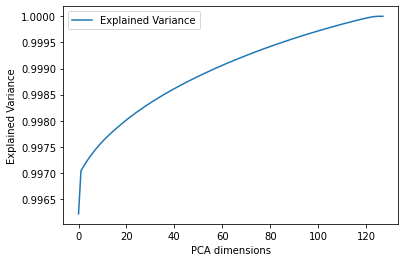

In [48]:
ax = sns.lineplot(data=PCAExplVar)
ax.set(xlabel='PCA dimensions', ylabel='Explained Variance')
plt.show()

Almost all variance is explained by the first PCA.

In [42]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Different data sets to try out

In [43]:
#X_train = X_train.copy().drop(columns=['ID'], axis = 1)

In [45]:
#X_test = X_test.copy().drop(columns=['ID'], axis = 1)

## Data set 1 - all features and minmax scaling

In [46]:
X_train_d1 = X_train_minmax
X_test_d1 = X_test_minmax

## Data set 2 - all features and zscore scaling

In [47]:
X_train_d2 = X_train_zscore
X_test_d2 = X_test_zscore

## Data set 3 - all features except 'Lipinski'

In [48]:
X_train_d3 = X_train.copy().drop(columns=['Lipinski'], axis = 1)

In [49]:
X_test_d3 = X_test.copy().drop(columns=['Lipinski'], axis = 1)

## Data set 4 - only features ['nrAtoms', 'ExactMolWT', 'Fragments']

In [50]:
X_train_d4 = X_train.copy()[['nrAtoms', 'ExactMolWT', 'Fragments']]

In [51]:
X_test_d4 = X_test.copy()[['nrAtoms', 'ExactMolWT', 'Fragments']]

## Data set 5 - only features ['nrAtoms', 'ExactMolWT', 'Fragments', 'Lipinski']

In [52]:
X_train_d5 = X_train.copy()[['nrAtoms', 'ExactMolWT', 'Fragments', 'Lipinski']]

In [53]:
X_test_d5 = X_test.copy()[['nrAtoms', 'ExactMolWT', 'Fragments', 'Lipinski']]

## Data set 6 - only fingerprint binaries 

In [54]:
X_train_d6 = X_train.copy().drop(columns=['nrAtoms', 'ExactMolWT', 'Fragments', 'Lipinski'], axis=1)

In [55]:
X_test_d6 = X_test.copy().drop(columns=['nrAtoms', 'ExactMolWT', 'Fragments', 'Lipinski'], axis=1)

## Data set 7 - PCA dimensionality reduction

In [56]:
X_train_d7 = X_train_pca

In [57]:
X_test_d7 = X_test_pca

# Model building 

In [58]:
# Different models to try out
clf1 = LogisticRegression(random_state=1, multi_class='auto')
clf2 = RandomForestClassifier()
clf3 = GaussianNB()
clf4 = AdaBoostClassifier(DecisionTreeClassifier())
clf5 = MLPClassifier(random_state=1, max_iter=100)
clf6 = GradientBoostingClassifier()
clf7 = LinearDiscriminantAnalysis()
eclf = VotingClassifier(
    estimators=[('rf', clf2), ('ada', clf4), ('gb', clf6)],
    voting='hard')

In [59]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

## Data set 1 - all features and minmax scaling

In [74]:
# model comparison
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Boosted Trees', 'Neural Network', 'Gradient Boosting', 'Linear Discriminant Analysis', 'Ensemble']):
        model = clf.fit(X_train_d1, y_train)
        score = clf.score(X_test_d1, y_test)
        print("Accuracy: %0.4f [%s]" % (score, label))
        print(confusion_matrix(clf.fit(X_train_d1, y_train).predict(X_test_d1), y_test).ravel())
        predictions = model.predict(X_test_d1)
        print("AUC: {:.4f}".format(auc(pd.DataFrame(predictions), y_test))) 
        print("Brier score: {:.4f}".format(brier_score(pd.DataFrame(predictions), y_test)))
        print("F1 score: {:.4f}".format(f1_score(pd.DataFrame(predictions), y_test)))
        print("Precision score: {:.4f}".format(precision_score(pd.DataFrame(predictions), y_test)))
        print("Recall score: {:.4f}".format(recall_score(pd.DataFrame(predictions), y_test)))

Accuracy: 0.9010 [Logistic Regression]
[21872  2403     0     0]
AUC: 0.4467
Brier score: 0.9010
F1 score: 0.0000
Precision score: 0.0000
Recall score: 0.0000


/Users/petrus/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7029 [Random Forest]
[15610   824  6262  1579]
AUC: 0.2855
Brier score: 0.7081
F1 score: 0.3083
Precision score: 0.6571
Recall score: 0.2014
Accuracy: 0.8726 [naive Bayes]
[20891  2112   981   291]
AUC: 0.4108
Brier score: 0.8726
F1 score: 0.1584
Precision score: 0.1211
Recall score: 0.2288
Accuracy: 0.5674 [Boosted Trees]
[12335   942  9537  1461]
AUC: 0.3718
Brier score: 0.5683
F1 score: 0.2180
Precision score: 0.6080
Recall score: 0.1328


/Users/petrus/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.8696 [Neural Network]


/Users/petrus/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[20914  2208   958   195]
AUC: 0.4291
Brier score: 0.8696
F1 score: 0.1097
Precision score: 0.0811
Recall score: 0.1691
Accuracy: 0.6399 [Gradient Boosting]
[14028   897  7844  1506]
AUC: 0.3287
Brier score: 0.6399
F1 score: 0.2563
Precision score: 0.6267
Recall score: 0.1611
Accuracy: 0.6204 [Linear Discriminant Analysis]
[13595   938  8277  1465]
AUC: 0.3500
Brier score: 0.6204
F1 score: 0.2413
Precision score: 0.6097
Recall score: 0.1504
Accuracy: 0.6800 [Ensemble]
[14873   809  6999  1594]
AUC: 0.2965
Brier score: 0.6784
F1 score: 0.2899
Precision score: 0.6633
Recall score: 0.1855


## Data set 2 - all features and zscore scaling

In [75]:
# model comparison
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Boosted Trees', 'Neural Network', 'Gradient Boosting', 'Linear Discriminant Analysis', 'Ensemble']):
        model = clf.fit(X_train_d2, y_train)
        score = clf.score(X_test_d2, y_test)
        print("Accuracy: %0.4f [%s]" % (score, label))
        print(confusion_matrix(clf.fit(X_train_d1, y_train).predict(X_test_d1), y_test).ravel())
        predictions = model.predict(X_test_d1)
        print("AUC: {:.4f}".format(auc(pd.DataFrame(predictions), y_test))) 
        print("Brier score: {:.4f}".format(brier_score(pd.DataFrame(predictions), y_test)))
        print("F1 score: {:.4f}".format(f1_score(pd.DataFrame(predictions), y_test)))
        print("Precision score: {:.4f}".format(precision_score(pd.DataFrame(predictions), y_test)))
        print("Recall score: {:.4f}".format(recall_score(pd.DataFrame(predictions), y_test)))

Accuracy: 0.9010 [Logistic Regression]
[21872  2403     0     0]
AUC: 0.4467
Brier score: 0.9010
F1 score: 0.0000
Precision score: 0.0000
Recall score: 0.0000


/Users/petrus/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7039 [Random Forest]
[15618   793  6254  1610]
AUC: 0.2793
Brier score: 0.7097
F1 score: 0.3136
Precision score: 0.6700
Recall score: 0.2047
Accuracy: 0.3825 [naive Bayes]
[20891  2112   981   291]
AUC: 0.4108
Brier score: 0.8726
F1 score: 0.1584
Precision score: 0.1211
Recall score: 0.2288
Accuracy: 0.5646 [Boosted Trees]
[12302   950  9570  1453]
AUC: 0.3794
Brier score: 0.5666
F1 score: 0.2164
Precision score: 0.6047
Recall score: 0.1318


/Users/petrus/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.1351 [Neural Network]


/Users/petrus/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[20914  2208   958   195]
AUC: 0.4291
Brier score: 0.8696
F1 score: 0.1097
Precision score: 0.0811
Recall score: 0.1691
Accuracy: 0.6399 [Gradient Boosting]
[14028   897  7844  1506]
AUC: 0.3287
Brier score: 0.6399
F1 score: 0.2563
Precision score: 0.6267
Recall score: 0.1611
Accuracy: 0.6204 [Linear Discriminant Analysis]
[13595   938  8277  1465]
AUC: 0.3500
Brier score: 0.6204
F1 score: 0.2413
Precision score: 0.6097
Recall score: 0.1504
Accuracy: 0.6781 [Ensemble]
[14851   816  7021  1587]
AUC: 0.2991
Brier score: 0.6772
F1 score: 0.2883
Precision score: 0.6604
Recall score: 0.1844


## Data set 3 - all features except 'Lipinski'

In [76]:
# model comparison
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Boosted Trees', 'Neural Network', 'Gradient Boosting', 'Linear Discriminant Analysis', 'Ensemble']):
        model = clf.fit(X_train_d3, y_train)
        score = clf.score(X_test_d3, y_test)
        print("Accuracy: %0.4f [%s]" % (score, label))
        print(confusion_matrix(clf.fit(X_train_d1, y_train).predict(X_test_d1), y_test).ravel())
        predictions = model.predict(X_test_d1)
        print("AUC: {:.4f}".format(auc(pd.DataFrame(predictions), y_test))) 
        print("Brier score: {:.4f}".format(brier_score(pd.DataFrame(predictions), y_test)))
        print("F1 score: {:.4f}".format(f1_score(pd.DataFrame(predictions), y_test)))
        print("Precision score: {:.4f}".format(precision_score(pd.DataFrame(predictions), y_test)))
        print("Recall score: {:.4f}".format(recall_score(pd.DataFrame(predictions), y_test)))

/Users/petrus/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6178 [Logistic Regression]
[21872  2403     0     0]
AUC: 0.4467
Brier score: 0.9010
F1 score: 0.0000
Precision score: 0.0000
Recall score: 0.0000


/Users/petrus/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7146 [Random Forest]
[15474   815  6398  1588]
AUC: 0.2870
Brier score: 0.7029
F1 score: 0.3057
Precision score: 0.6608
Recall score: 0.1988
Accuracy: 0.4243 [naive Bayes]
[20891  2112   981   291]
AUC: 0.4108
Brier score: 0.8726
F1 score: 0.1584
Precision score: 0.1211
Recall score: 0.2288
Accuracy: 0.5897 [Boosted Trees]
[12227   950  9645  1453]
AUC: 0.3804
Brier score: 0.5635
F1 score: 0.2152
Precision score: 0.6047
Recall score: 0.1309
Accuracy: 0.8221 [Neural Network]


/Users/petrus/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[20914  2208   958   195]
AUC: 0.4291
Brier score: 0.8696
F1 score: 0.1097
Precision score: 0.0811
Recall score: 0.1691
Accuracy: 0.6422 [Gradient Boosting]
[14028   897  7844  1506]
AUC: 0.3287
Brier score: 0.6399
F1 score: 0.2563
Precision score: 0.6267
Recall score: 0.1611
Accuracy: 0.6209 [Linear Discriminant Analysis]
[13595   938  8277  1465]
AUC: 0.3500
Brier score: 0.6204
F1 score: 0.2413
Precision score: 0.6097
Recall score: 0.1504
Accuracy: 0.6837 [Ensemble]
[14901   841  6971  1562]
AUC: 0.3018
Brier score: 0.6782
F1 score: 0.2857
Precision score: 0.6500
Recall score: 0.1831


## Data set 4 - only features ['nrAtoms', 'ExactMolWT', 'Fragments']

In [77]:
# model comparison
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Boosted Trees', 'Neural Network', 'Gradient Boosting', 'Linear Discriminant Analysis', 'Ensemble']):
        model = clf.fit(X_train_d4, y_train)
        score = clf.score(X_test_d4, y_test)
        print("Accuracy: %0.4f [%s]" % (score, label))
        print(confusion_matrix(clf.fit(X_train_d1, y_train).predict(X_test_d1), y_test).ravel())
        predictions = model.predict(X_test_d1)
        print("AUC: {:.4f}".format(auc(pd.DataFrame(predictions), y_test))) 
        print("Brier score: {:.4f}".format(brier_score(pd.DataFrame(predictions), y_test)))
        print("F1 score: {:.4f}".format(f1_score(pd.DataFrame(predictions), y_test)))
        print("Precision score: {:.4f}".format(precision_score(pd.DataFrame(predictions), y_test)))
        print("Recall score: {:.4f}".format(recall_score(pd.DataFrame(predictions), y_test)))

Accuracy: 0.5553 [Logistic Regression]
[21872  2403     0     0]
AUC: 0.4467
Brier score: 0.9010
F1 score: 0.0000
Precision score: 0.0000
Recall score: 0.0000


/Users/petrus/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5348 [Random Forest]
[15537   799  6335  1604]
AUC: 0.2834
Brier score: 0.7061
F1 score: 0.3102
Precision score: 0.6675
Recall score: 0.2020
Accuracy: 0.2326 [naive Bayes]
[20891  2112   981   291]
AUC: 0.4108
Brier score: 0.8726
F1 score: 0.1584
Precision score: 0.1211
Recall score: 0.2288
Accuracy: 0.5221 [Boosted Trees]
[12244   963  9628  1440]
AUC: 0.3774
Brier score: 0.5637
F1 score: 0.2138
Precision score: 0.5993
Recall score: 0.1301
Accuracy: 0.2863 [Neural Network]


/Users/petrus/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[20914  2208   958   195]
AUC: 0.4291
Brier score: 0.8696
F1 score: 0.1097
Precision score: 0.0811
Recall score: 0.1691
Accuracy: 0.4793 [Gradient Boosting]
[14028   897  7844  1506]
AUC: 0.3287
Brier score: 0.6399
F1 score: 0.2563
Precision score: 0.6267
Recall score: 0.1611
Accuracy: 0.5487 [Linear Discriminant Analysis]
[13595   938  8277  1465]
AUC: 0.3500
Brier score: 0.6204
F1 score: 0.2413
Precision score: 0.6097
Recall score: 0.1504
Accuracy: 0.5158 [Ensemble]
[14879   827  6993  1576]
AUC: 0.2993
Brier score: 0.6779
F1 score: 0.2873
Precision score: 0.6558
Recall score: 0.1839


## Data set 5 - only features ['nrAtoms', 'ExactMolWT', 'Fragments', 'Lipinski']

In [78]:
# model comparison
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Boosted Trees', 'Neural Network', 'Gradient Boosting', 'Linear Discriminant Analysis', 'Ensemble']):
        model = clf.fit(X_train_d5, y_train)
        score = clf.score(X_test_d5, y_test)
        print("Accuracy: %0.4f [%s]" % (score, label))
        print(confusion_matrix(clf.fit(X_train_d1, y_train).predict(X_test_d1), y_test).ravel())
        predictions = model.predict(X_test_d1)
        print("AUC: {:.4f}".format(auc(pd.DataFrame(predictions), y_test))) 
        print("Brier score: {:.4f}".format(brier_score(pd.DataFrame(predictions), y_test)))
        print("F1 score: {:.4f}".format(f1_score(pd.DataFrame(predictions), y_test)))
        print("Precision score: {:.4f}".format(precision_score(pd.DataFrame(predictions), y_test)))
        print("Recall score: {:.4f}".format(recall_score(pd.DataFrame(predictions), y_test)))

Accuracy: 0.5483 [Logistic Regression]
[21872  2403     0     0]
AUC: 0.4467
Brier score: 0.9010
F1 score: 0.0000
Precision score: 0.0000
Recall score: 0.0000


/Users/petrus/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5290 [Random Forest]
[15476   815  6396  1588]
AUC: 0.2880
Brier score: 0.7029
F1 score: 0.3058
Precision score: 0.6608
Recall score: 0.1989
Accuracy: 0.2682 [naive Bayes]
[20891  2112   981   291]
AUC: 0.4108
Brier score: 0.8726
F1 score: 0.1584
Precision score: 0.1211
Recall score: 0.2288
Accuracy: 0.5263 [Boosted Trees]
[12352   970  9520  1433]
AUC: 0.3819
Brier score: 0.5679
F1 score: 0.2146
Precision score: 0.5963
Recall score: 0.1308
Accuracy: 0.1308 [Neural Network]


/Users/petrus/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[20914  2208   958   195]
AUC: 0.4291
Brier score: 0.8696
F1 score: 0.1097
Precision score: 0.0811
Recall score: 0.1691
Accuracy: 0.4793 [Gradient Boosting]
[14028   897  7844  1506]
AUC: 0.3287
Brier score: 0.6399
F1 score: 0.2563
Precision score: 0.6267
Recall score: 0.1611
Accuracy: 0.5487 [Linear Discriminant Analysis]
[13595   938  8277  1465]
AUC: 0.3500
Brier score: 0.6204
F1 score: 0.2413
Precision score: 0.6097
Recall score: 0.1504
Accuracy: 0.5165 [Ensemble]
[14856   798  7016  1605]
AUC: 0.2952
Brier score: 0.6781
F1 score: 0.2912
Precision score: 0.6679
Recall score: 0.1862


## Data set 6 - only fingerprint binaries 

In [79]:
# model comparison
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Boosted Trees', 'Neural Network', 'Gradient Boosting', 'Linear Discriminant Analysis', 'Ensemble']):
        model = clf.fit(X_train_d6, y_train)
        score = clf.score(X_test_d6, y_test)
        print("Accuracy: %0.4f [%s]" % (score, label))
        print(confusion_matrix(clf.fit(X_train_d1, y_train).predict(X_test_d1), y_test).ravel())
        predictions = model.predict(X_test_d1)
        print("AUC: {:.4f}".format(auc(pd.DataFrame(predictions), y_test))) 
        print("Brier score: {:.4f}".format(brier_score(pd.DataFrame(predictions), y_test)))
        print("F1 score: {:.4f}".format(f1_score(pd.DataFrame(predictions), y_test)))
        print("Precision score: {:.4f}".format(precision_score(pd.DataFrame(predictions), y_test)))
        print("Recall score: {:.4f}".format(recall_score(pd.DataFrame(predictions), y_test)))

Accuracy: 0.6199 [Logistic Regression]
[21872  2403     0     0]
AUC: 0.4467
Brier score: 0.9010
F1 score: 0.0000
Precision score: 0.0000
Recall score: 0.0000


/Users/petrus/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7287 [Random Forest]
[15413   812  6459  1591]
AUC: 0.2883
Brier score: 0.7005
F1 score: 0.3044
Precision score: 0.6621
Recall score: 0.1976
Accuracy: 0.4991 [naive Bayes]
[20891  2112   981   291]
AUC: 0.4108
Brier score: 0.8726
F1 score: 0.1584
Precision score: 0.1211
Recall score: 0.2288
Accuracy: 0.6428 [Boosted Trees]
[12257   956  9615  1447]
AUC: 0.3751
Brier score: 0.5645
F1 score: 0.2149
Precision score: 0.6022
Recall score: 0.1308


/Users/petrus/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.6693 [Neural Network]


/Users/petrus/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[20914  2208   958   195]
AUC: 0.4291
Brier score: 0.8696
F1 score: 0.1097
Precision score: 0.0811
Recall score: 0.1691
Accuracy: 0.6667 [Gradient Boosting]
[14027   897  7845  1506]
AUC: 0.3287
Brier score: 0.6399
F1 score: 0.2563
Precision score: 0.6267
Recall score: 0.1611
Accuracy: 0.6207 [Linear Discriminant Analysis]
[13595   938  8277  1465]
AUC: 0.3500
Brier score: 0.6204
F1 score: 0.2413
Precision score: 0.6097
Recall score: 0.1504
Accuracy: 0.7110 [Ensemble]
[14921   832  6951  1571]
AUC: 0.3018
Brier score: 0.6794
F1 score: 0.2876
Precision score: 0.6538
Recall score: 0.1843


## Data set 7 - PCA

In [80]:
# model comparison
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Boosted Trees', 'Neural Network', 'Gradient Boosting', 'Linear Discriminant Analysis', 'Ensemble']):
        model = clf.fit(X_train_d7, y_train)
        score = clf.score(X_test_d7, y_test)
        print("Accuracy: %0.4f [%s]" % (score, label))
        print(confusion_matrix(clf.fit(X_train_d1, y_train).predict(X_test_d1), y_test).ravel())
        predictions = model.predict(X_test_d1)
        print("AUC: {:.4f}".format(auc(pd.DataFrame(predictions), y_test))) 
        print("Brier score: {:.4f}".format(brier_score(pd.DataFrame(predictions), y_test)))
        print("F1 score: {:.4f}".format(f1_score(pd.DataFrame(predictions), y_test)))
        print("Precision score: {:.4f}".format(precision_score(pd.DataFrame(predictions), y_test)))
        print("Recall score: {:.4f}".format(recall_score(pd.DataFrame(predictions), y_test)))

Accuracy: 0.5686 [Logistic Regression]
[21872  2403     0     0]
AUC: 0.4467
Brier score: 0.9010
F1 score: 0.0000
Precision score: 0.0000
Recall score: 0.0000


/Users/petrus/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5412 [Random Forest]
[15552   799  6320  1604]
AUC: 0.2816
Brier score: 0.7067
F1 score: 0.3106
Precision score: 0.6675
Recall score: 0.2024
Accuracy: 0.6394 [naive Bayes]
[20891  2112   981   291]
AUC: 0.4108
Brier score: 0.8726
F1 score: 0.1584
Precision score: 0.1211
Recall score: 0.2288
Accuracy: 0.5125 [Boosted Trees]
[12200   957  9672  1446]
AUC: 0.3762
Brier score: 0.5621
F1 score: 0.2139
Precision score: 0.6017
Recall score: 0.1301
Accuracy: 0.6283 [Neural Network]


/Users/petrus/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[20914  2208   958   195]
AUC: 0.4291
Brier score: 0.8696
F1 score: 0.1097
Precision score: 0.0811
Recall score: 0.1691
Accuracy: 0.5144 [Gradient Boosting]
[14028   897  7844  1506]
AUC: 0.3287
Brier score: 0.6399
F1 score: 0.2563
Precision score: 0.6267
Recall score: 0.1611
Accuracy: 0.5684 [Linear Discriminant Analysis]
[13595   938  8277  1465]
AUC: 0.3500
Brier score: 0.6204
F1 score: 0.2413
Precision score: 0.6097
Recall score: 0.1504
Accuracy: 0.5222 [Ensemble]
[14874   835  6998  1568]
AUC: 0.3034
Brier score: 0.6773
F1 score: 0.2859
Precision score: 0.6525
Recall score: 0.1830


# Auto-sklearn

In [81]:
import autosklearn.classification
import sklearn.metrics

## Data set 1 - all features and minmax scaling

In [82]:
automl = autosklearn.classification.AutoSklearnClassifier()
automl.fit(X_train_d1, y_train)
y_hat = automl.predict(X_test_d1)
print("Accuracy: %0.4f [%s]" % sklearn.metrics.accuracy_score(y_test, y_hat))

/Users/petrus/opt/anaconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56113 instead
  warnings.warn(


[ERROR] [2020-12-08 18:18:42,824:AutoMLSMBO(1)::4f2977d818f7f4494f1dfe016939a9b5] Error getting metafeatures: Can't pickle local object 'Client.__init__.<locals>.<lambda>'
[ERROR] [2020-12-08 18:18:42,838:AutoMLSMBO(1)::4f2977d818f7f4494f1dfe016939a9b5] Error getting metafeatures (encoded) : Can't pickle local object 'Client.__init__.<locals>.<lambda>'


TypeError: not enough arguments for format string

In [83]:
print(automl.get_models_with_weights())

[(0.74, SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'lda', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessing:numerical_transformer:imputation:strategy': 'median', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize', 'feature_preprocessor:__choice__': 'pca', 'classifier:lda:n_components': 230, 'classifier:lda:shrinkage': 'None', 'classifier:lda:tol': 0.004697509790516932, 'feature_preprocessor:pca:keep_variance': 0.9805398508640487, 'feature_preprocessor:pca:whiten': 'True'},
dataset_properties={
  'task': 1,
  'sparse': False,
  'multilabel': False,
  'multiclass': False,
  'target_type': 'classification',
  'signed': False})), (0.1, SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'random_forest', 'data_preprocessing:categorical

## Data set 2 - all features and zscore scaling

In [ ]:
automl = autosklearn.classification.AutoSklearnClassifier()
automl.fit(X_train_d2, y_train)
y_hat = automl.predict(X_test_d2)
print("Accuracy: %0.4f [%s]" % sklearn.metrics.accuracy_score(y_test, y_hat))

In [ ]:
print(automl.get_models_with_weights())

## Data set 3 - all features except 'Lipinski'

In [ ]:
automl = autosklearn.classification.AutoSklearnClassifier()
automl.fit(X_train_d3, y_train)
y_hat = automl.predict(X_test_d3)
print("Accuracy: %0.4f [%s]" % sklearn.metrics.accuracy_score(y_test, y_hat))

In [ ]:
print(automl.get_models_with_weights())

In [ ]:
print(automl.show_models())

In [ ]:
automl.cv_results_

In [ ]:
automl.sprint_statistics()

## Data set 4 - only features ['nrAtoms', 'ExactMolWT', 'Fragments']

In [ ]:
automl = autosklearn.classification.AutoSklearnClassifier()
automl.fit(X_train_d4, y_train)
y_hat = automl.predict(X_test_d4)
print("Accuracy: %0.4f [%s]" % sklearn.metrics.accuracy_score(y_test, y_hat))

In [ ]:
print(automl.get_models_with_weights())

## Data set 5 - only fingerprint binaries 

In [ ]:
automl = autosklearn.classification.AutoSklearnClassifier()
automl.fit(X_train_d5, y_train)
y_hat = automl.predict(X_test_d5)
print("Accuracy: %0.4f [%s]" % sklearn.metrics.accuracy_score(y_test, y_hat))

In [ ]:
print(automl.get_models_with_weights())

## Data set 6 - only fingerprint binaries 

In [ ]:
automl = autosklearn.classification.AutoSklearnClassifier()
automl.fit(X_train_d6, y_train)
y_hat = automl.predict(X_test_d6)
print("Accuracy: %0.4f [%s]" % sklearn.metrics.accuracy_score(y_test, y_hat))

In [ ]:
print(automl.get_models_with_weights())

## Data set 7 - PCA

In [ ]:
automl = autosklearn.classification.AutoSklearnClassifier()
automl.fit(X_train_d7, y_train)
y_hat = automl.predict(X_test_d7)
print("Accuracy: %0.4f [%s]" % sklearn.metrics.accuracy_score(y_test, y_hat))

In [ ]:
print(automl.get_models_with_weights())

# Model selection

# Parameter setting